# Imputación de datos
La presencia de datos faltantes, es la situación a la que permanentemente se enfrentan investigadores y tomadores de decisiones. Disponer de un archivo de datos completos es ideal, pero aplicar métodos de imputación inapropiados para lograrlo, puede generar más problemas de los que resuelve.

El propósito del presente **notebook** será presentar un método de imputación de datos faltantes haciendo uso de componentes principales. Para ello trabajaremos con una base de datos que contiene imágenes de perros y gatos.

In [2]:
load("gatosperros.RData")

La siguientes funciones permiten graficar la imagen correspondiente a cada animal. La primera función muestra la imagen con los datos completos, las segunda enmascara algunos pixeles, simulando una imagen con datos faltantes.

In [6]:
## función de graficación:
plotcd <- function(v){
  x <- matrix(v,64,64)
  image(1:65,1:65,t(apply(x,2,rev)),asp=1,xaxt="n",yaxt="n",
        col=grey((0:255)/255),ann=FALSE,bty="n")
}

## Visualización vector enmascarado
plotcdm <- function(v, m){
  ina <- which(m==0)
  w <- v
  w[ina] <- NA
  x <- matrix(w,64,64)
  image(1:65,1:65,t(apply(x,2,rev)),asp=1,xaxt="n",yaxt="n",
        col=grey((0:255)/255),ann=FALSE,bty="n")
}

## Función de generación de máscaras
## 0 en la máscara indica que el dato se omite
## 1 en la máscara indica que el dato se conserva
get.mask <- function(d1,# Número de filas
                     d2,# Número de columnas
                     p# probabilidad de omitir un dato
){
  return(matrix(sample(c(0,1),d1*d2,prob=c(p,1-p),replace=TRUE), d1, d2))
}

Vamos a partir los datos en conjuntos de entrenamiento y prueba. Centramos además cada conjunto de datos usando como base los gatos de entrenamiento.

In [5]:
set.seed(7931)

## Partición
ind.gatostest <- sample(1:99, 9, replace = FALSE)
gatos.test <- dm[ind.gatostest, ]
gatos.train <- dm[1:99, ][-ind.gatostest, ]

ind.perrostest <- sample(1:99, 9, replace = FALSE)
perros.test <- dm[100:198, ][ind.perrostest, ]
perros.train <- dm[100:198, ][-ind.perrostest, ]


## Centrado
centro.gatos <- colMeans(gatos.train)

gatos.train <- gatos.train - matrix(centro.gatos,nrow(gatos.train),ncol(gatos.train),byrow=TRUE)
gatos.test <- gatos.test - matrix(centro.gatos,nrow(gatos.test),ncol(gatos.test),byrow=TRUE)
perros.train <- perros.train - matrix(centro.gatos,nrow(perros.train),ncol(perros.train),byrow=TRUE)
perros.test <- perros.test - matrix(centro.gatos,nrow(perros.test),ncol(perros.test),byrow=TRUE)

Generamos la base de componentes principales de los gatos de entrenamiento. Además generamos una máscara con un 20% pixeles faltantes para todos los gatos de prueba

In [8]:
### Generación de la base
pc <- prcomp(gatos.train)
dim(pc$x)
matriz.proyec <- pc$rotation

### Generamos la máscara
mask.gatos.test <- get.mask(nrow(gatos.test),
                            ncol(gatos.test),
                            p=0.2)

[1] 90 90

Aplicamos entonces el siguiente algoritmo para la reconstrucción de los datos:

In [9]:
n <- 90
matriz.proyec.n <- matriz.proyec[, 1:n]

### Reconstrucción
gatos.test.filled <- 0*gatos.test
for(igs in 1:nrow(gatos.test)){ # Para cada gato de prueba
  gato <- gatos.test[igs, , drop=FALSE]
  mask <- mask.gatos.test[igs, , drop=FALSE]
  i.mask <- (which(mask==1))
  g.mask <- gato[1, i.mask, drop=FALSE]
  u.mask <- matriz.proyec.n[i.mask, ]
  M <- t(u.mask)%*%u.mask
  f <- t(g.mask %*% u.mask)
  a <- solve(M,f)
  
  gatos.test.filled[igs,] <- t(matriz.proyec.n %*% a)
}

Seleccionamos de forma aleatoria un gato reconstruído. Nótese que en el proceso de reconstrucción, el resultado aún conserva los rasgos característicos de un gato, aunque le cambió levemente la apariencia.

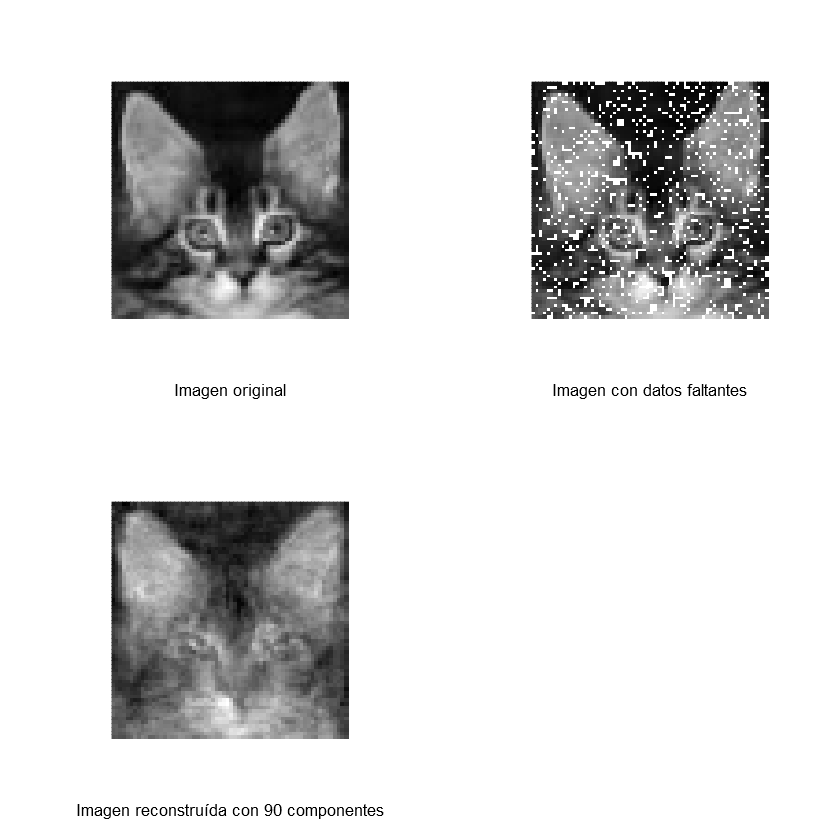

In [10]:
## Selección de gato reconstruído
i.gtest <- sample(1:nrow(gatos.test),1)

## Gráfica del gato
par(pty="s")
layout(matrix(c(1,2,3,4),2,2,byrow=TRUE))
plotcd(gatos.test[i.gtest,])
title(xlab="Imagen original")
plotcdm(gatos.test[i.gtest,], mask.gatos.test[i.gtest,])
title(xlab="Imagen con datos faltantes")
plotcd(gatos.test.filled[i.gtest,])
title(xlab=paste("Imagen reconstruída con ", n, " componentes",sep=""))

### Reconstrucción de los perros de prueba
En este caso observamos lo que sucede cuando se realiza imputación de datos, tomando como base información que difiere en cuanto a sus características a la información que queremos completar. Usando como base de imputación las componentes principales de los gatos, reconstruímos a continuación la imagen de un perro que ha sido enmarcarada en un 20% del total de sus pixeles:

In [13]:
mask.perros.test <- get.mask(nrow(perros.test),
                             ncol(perros.test),
                             p=0.2)

n <- 90
matriz.proyec.n <- matriz.proyec[, 1:n]

### Reconstrucción
perros.test.filled <- 0*perros.test
for(igs in 1:nrow(gatos.test)){ # Para cada gato de prueba
     perro <- perros.test[igs, , drop=FALSE]
     mask <- mask.perros.test[igs, , drop=FALSE]
     i.mask <- (which(mask==1))
     g.mask <- perro[1, i.mask, drop=FALSE]
     u.mask <- matriz.proyec.n[i.mask, ]
     M <- t(u.mask)%*%u.mask
     f <- t(g.mask %*% u.mask)
     a <- solve(M,f)
     
     perros.test.filled[igs,] <- t(matriz.proyec.n %*% a)
}


AL graficar los resultados se observa de inmediato que la apariencia del perro se ha perdido y peor aún ha tomado la imagen la apariencia de un gato

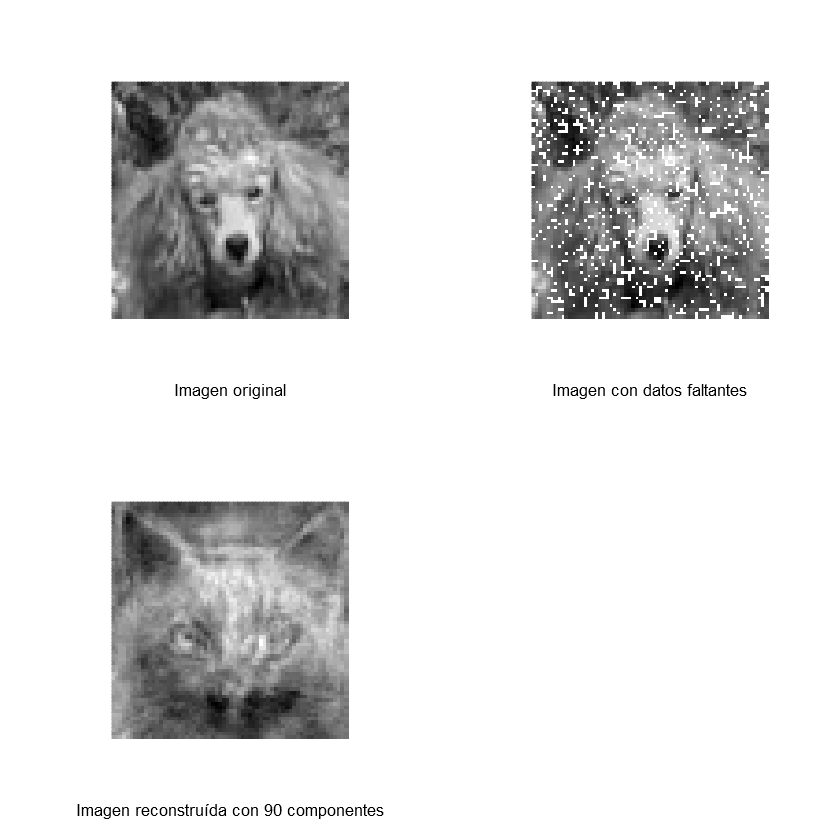

In [14]:
## Selección de perro de prueba
i.gtest <- sample(1:nrow(perros.test),1)

## Gráfica de perro reconstruído
par(pty="s")
layout(matrix(c(1,2,3,4),2,2,byrow=TRUE))
plotcd(perros.test[i.gtest,])
title(xlab="Imagen original")
plotcdm(perros.test[i.gtest,], mask.perros.test[i.gtest,])
title(xlab="Imagen con datos faltantes")
plotcd(perros.test.filled[i.gtest,])
title(xlab=paste("Imagen reconstruída con ", n, " componentes",sep=""))

## Imputación con múltiple iteraciones
A continuación vamos a definir un algoritmo que realiza varias iteraciones que permiten mejorar la calidad de la imputación. En cada iteración, se calculan las componentes principales y se imputan los valores perdidos en los datos.

In [15]:
## Gatos enmarcarados al 10%
mask.gatos.train <- get.mask(nrow(gatos.train),
                            ncol(gatos.train),
                            p=0.1)

## Seleccionamos un gato de entrenamiento
i.gtrain <- sample(1:nrow(gatos.train),1)

En este ejemplo vamos a tomar por defecto 10 componentes principales para realizar el proceso de imputación. Se define además un vector de errores, el cual es el resultado de contrastar el gato original contra cada gato resultante de cada iteración. Nótese que en cada iteración el resultado parece mejorar hasta cierto nivel.

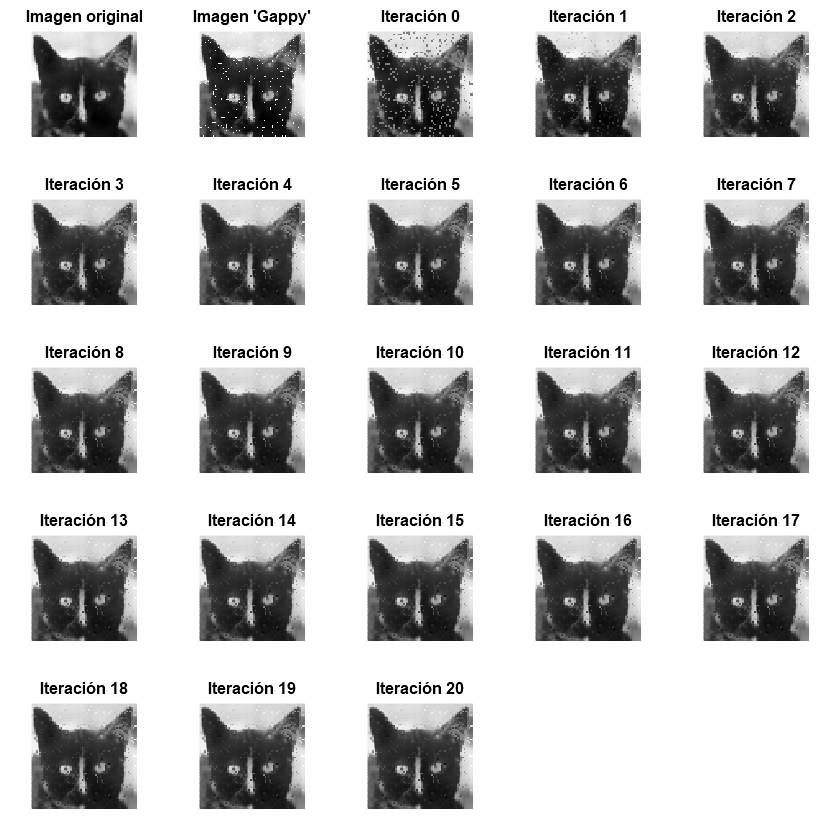

In [20]:
par(pty="s",mar=rep(2,4))
layout(matrix(1:25,5,5,byrow=TRUE))
plotcd(gatos.train[i.gtrain,])
title(main="Imagen original")

gatos.train.masked <- gatos.train
i.gap <- which(mask.gatos.train==0)
gatos.train.masked[i.gap] <- NA
X <- gatos.train.masked

plotcd(gatos.train.masked[i.gtrain,])
title(main="Imagen 'Gappy'")

### Iteración 0: Llenar los faltantes con el promedio de cada pixel
X_0 <- matrix(colMeans(gatos.train.masked, na.rm = TRUE),
              nrow(gatos.train), ncol(gatos.train), byrow=TRUE)

X[i.gap] <- X_0[i.gap]
plotcd(X[i.gtrain,])
title(main="Iteración 0")

## Vector de errores
err <- NULL
err[1] <- norm(gatos.train[i.gtrain,]-X[i.gtrain, ],"2")

## Componentes a utilizar
n <- 10

### 20 iteraciones
X_i <- 0 * gatos.train
for(iter in 1:20){
  ### Generación de la base
  pc <- prcomp(X)
  matriz.proyec.n <- pc$rotation[, 1:n]
  for(igs in 1:nrow(gatos.train)){
    gato <- X[igs, , drop=FALSE]
    mask <- mask.gatos.train[igs, , drop=FALSE]
    i.mask <- (which(mask==1))
    g.mask <- gato[1, i.mask, drop=FALSE]
    u.mask <- matriz.proyec.n[i.mask, ]
    M <- t(u.mask)%*%u.mask
    f <- t(g.mask %*% u.mask)
    a <- solve(M,f)
    X_i[igs, ] <- t(matriz.proyec.n %*% a)
  }
  X[i.gap] <- X_i[i.gap]
  
  plotcd(X[i.gtrain,])
  title(main=paste("Iteración", iter, sep=" "))
  
  ## Calcula error
  err[iter + 1] <- norm(gatos.train[i.gtrain,]-X[i.gtrain, ],"2")
}


La siguiente tabla muestra el error resultante en cada iteración, donde puede notarse que los cambios a partir de la quinta iteración son imperceptibles

In [19]:
res_pc10 <- data.frame(Iteración=0:20, error=err)
res_pc10

Iteración,error
0,2132.7112
1,1439.7249
2,1085.1568
3,953.6746
4,914.7018
5,905.0213
6,903.4810
7,903.8542
8,904.4299
9,904.8073


Revisemos un resultado alterno, utilizando en este caso 50 componentes. El cálculo computacional resulta mas extenso, por lo que tardará unos segundos mas

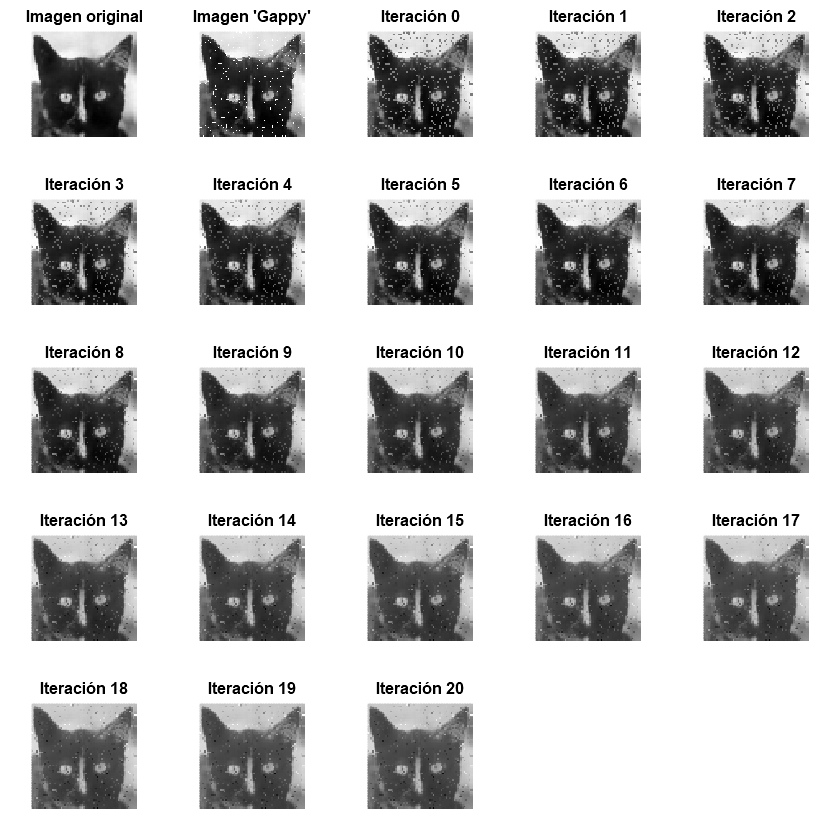

In [21]:
par(pty="s",mar=rep(2,4))
layout(matrix(1:25,5,5,byrow=TRUE))
plotcd(gatos.train[i.gtrain,])
title(main="Imagen original")

gatos.train.masked <- gatos.train
i.gap <- which(mask.gatos.train==0)
gatos.train.masked[i.gap] <- NA
X <- gatos.train.masked

plotcd(gatos.train.masked[i.gtrain,])
title(main="Imagen 'Gappy'")

### Iteración 0: Llenar los faltantes con el promedio de cada pixel
X_0 <- matrix(colMeans(gatos.train.masked, na.rm = TRUE),
              nrow(gatos.train), ncol(gatos.train), byrow=TRUE)

X[i.gap] <- X_0[i.gap]
plotcd(X[i.gtrain,])
title(main="Iteración 0")

## Vector de errores
err <- NULL
err[1] <- norm(gatos.train[i.gtrain,]-X[i.gtrain, ],"2")

## Componentes a utilizar
n <- 50

### 20 iteraciones
X_i <- 0 * gatos.train
for(iter in 1:20){
  ### Generación de la base
  pc <- prcomp(X)
  matriz.proyec.n <- pc$rotation[, 1:n]
  for(igs in 1:nrow(gatos.train)){
    gato <- X[igs, , drop=FALSE]
    mask <- mask.gatos.train[igs, , drop=FALSE]
    i.mask <- (which(mask==1))
    g.mask <- gato[1, i.mask, drop=FALSE]
    u.mask <- matriz.proyec.n[i.mask, ]
    M <- t(u.mask)%*%u.mask
    f <- t(g.mask %*% u.mask)
    a <- solve(M,f)
    X_i[igs, ] <- t(matriz.proyec.n %*% a)
  }
  X[i.gap] <- X_i[i.gap]
  
  plotcd(X[i.gtrain,])
  title(main=paste("Iteración", iter, sep=" "))
  
  ## Calcula error
  err[iter + 1] <- norm(gatos.train[i.gtrain,]-X[i.gtrain, ],"2")
}

Evaluamos los resultados en la siguiente tabla

In [22]:
res_pc50 <- data.frame(Iteración=0:20, error=err)
res_pc50

Iteración,error
0,2132.711
1,1940.965
2,1776.100
3,1627.328
4,1496.787
5,1386.177
6,1296.422
7,1227.154
8,1176.578
9,1141.860


A pesar de haber usado una mayor cantidad de información, el resultado usando 10 componentes resulta mas favorable.